Loading datasets...
Dataset shapes:
MIT-BIH train: (87554, 188)
MIT-BIH test: (21892, 188)
PTB-DB normal: (4046, 188)
PTB-DB abnormal: (10506, 188)

--- Initial EDA ---

MIT-BIH train class distribution:
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

PTB-DB class distribution:
label
1    10506
0     4046
Name: count, dtype: int64


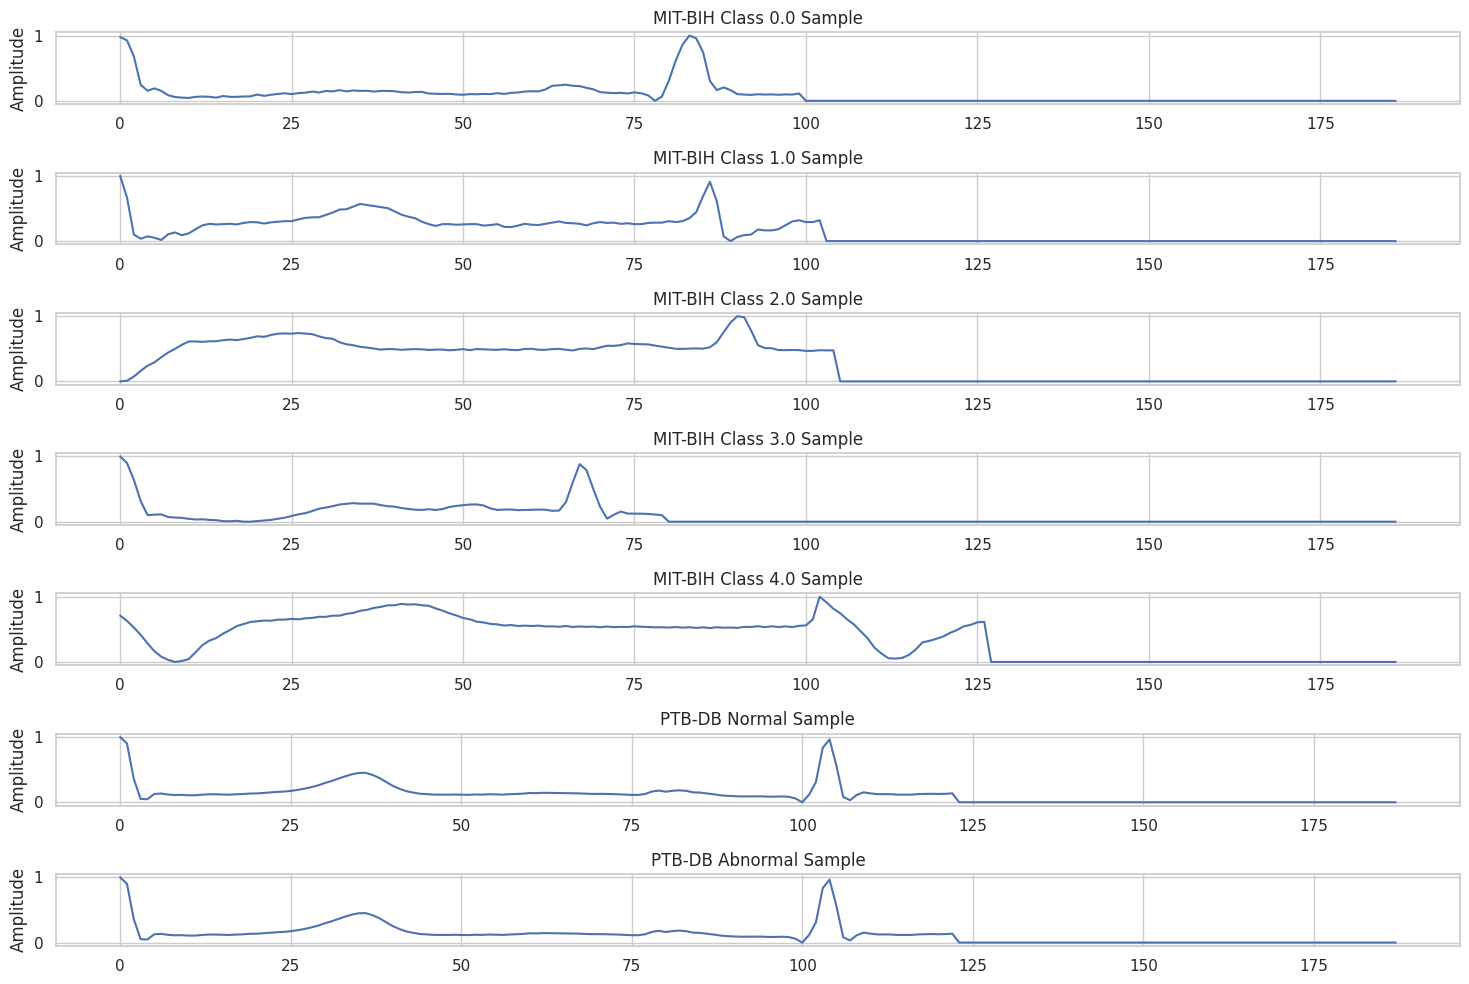

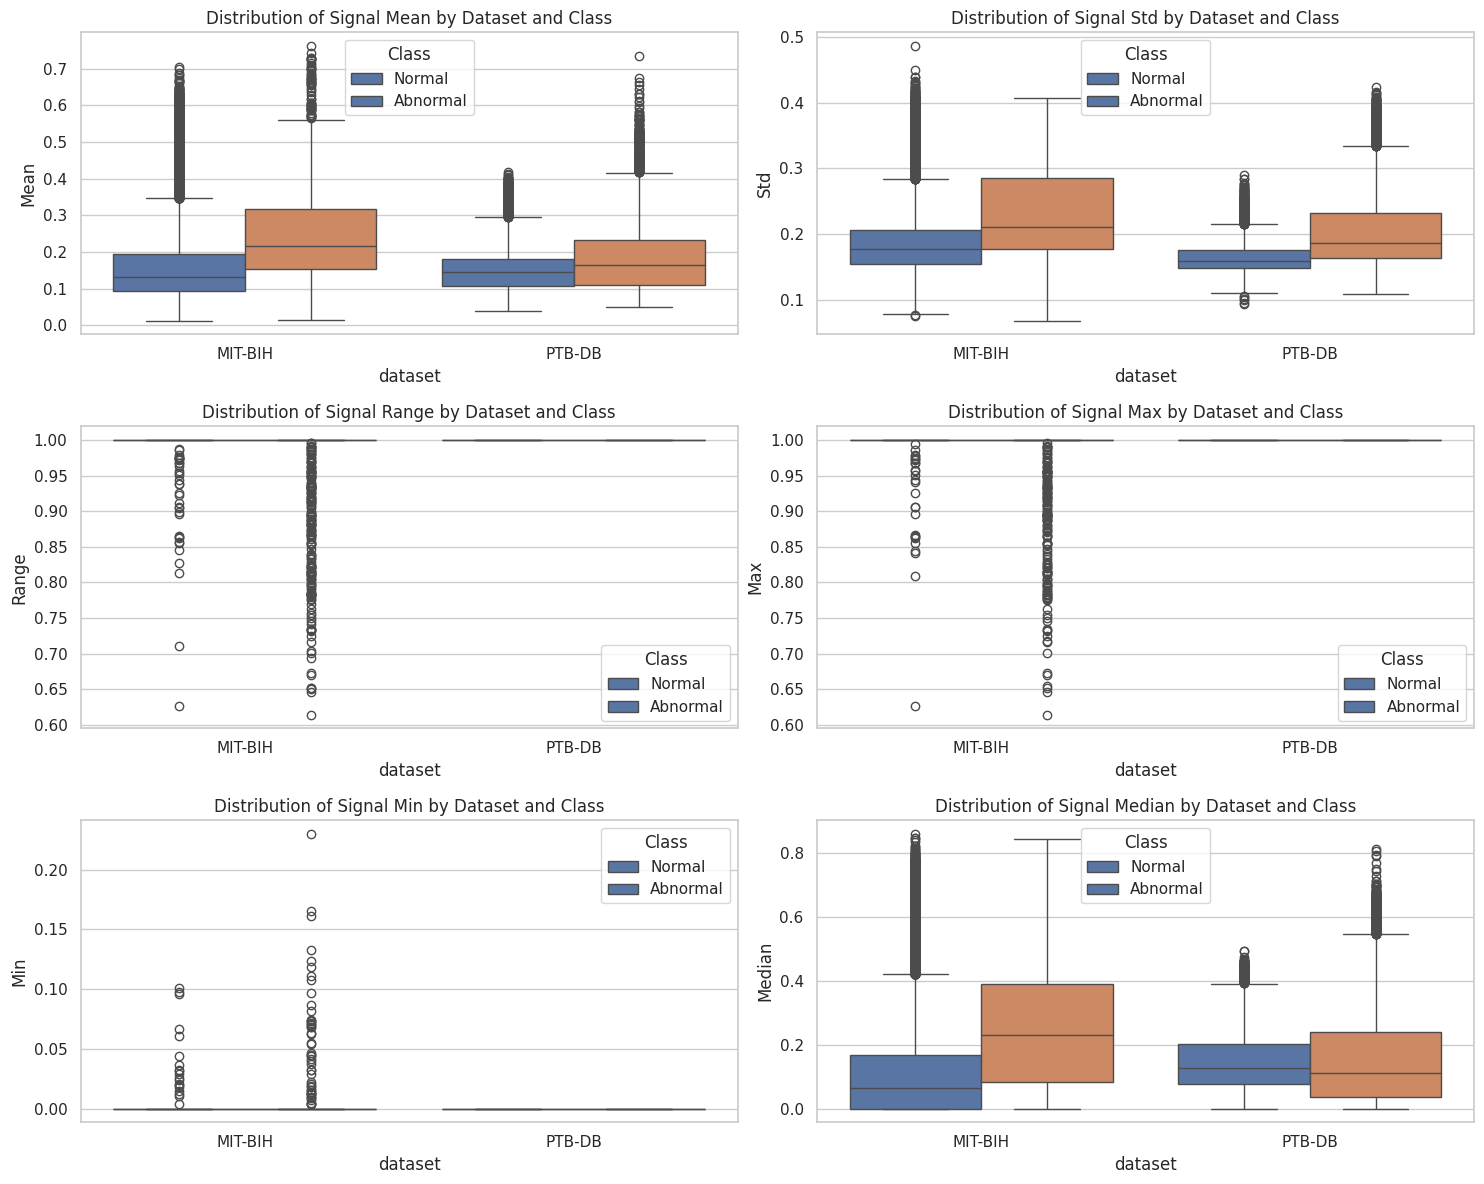


--- Data Preprocessing ---

Missing values in MIT-BIH: 0
Missing values in PTB-DB: 0

Raw data shape: (123998, 188)
Engineered features shape: (123998, 15)
Combined labels shape: (123998,)


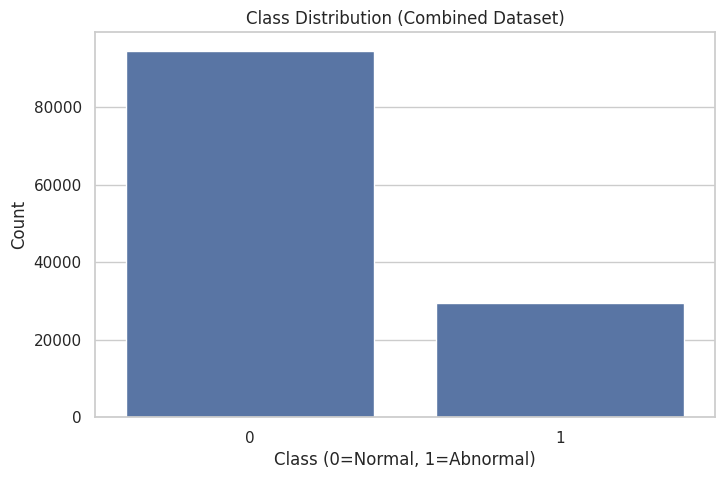

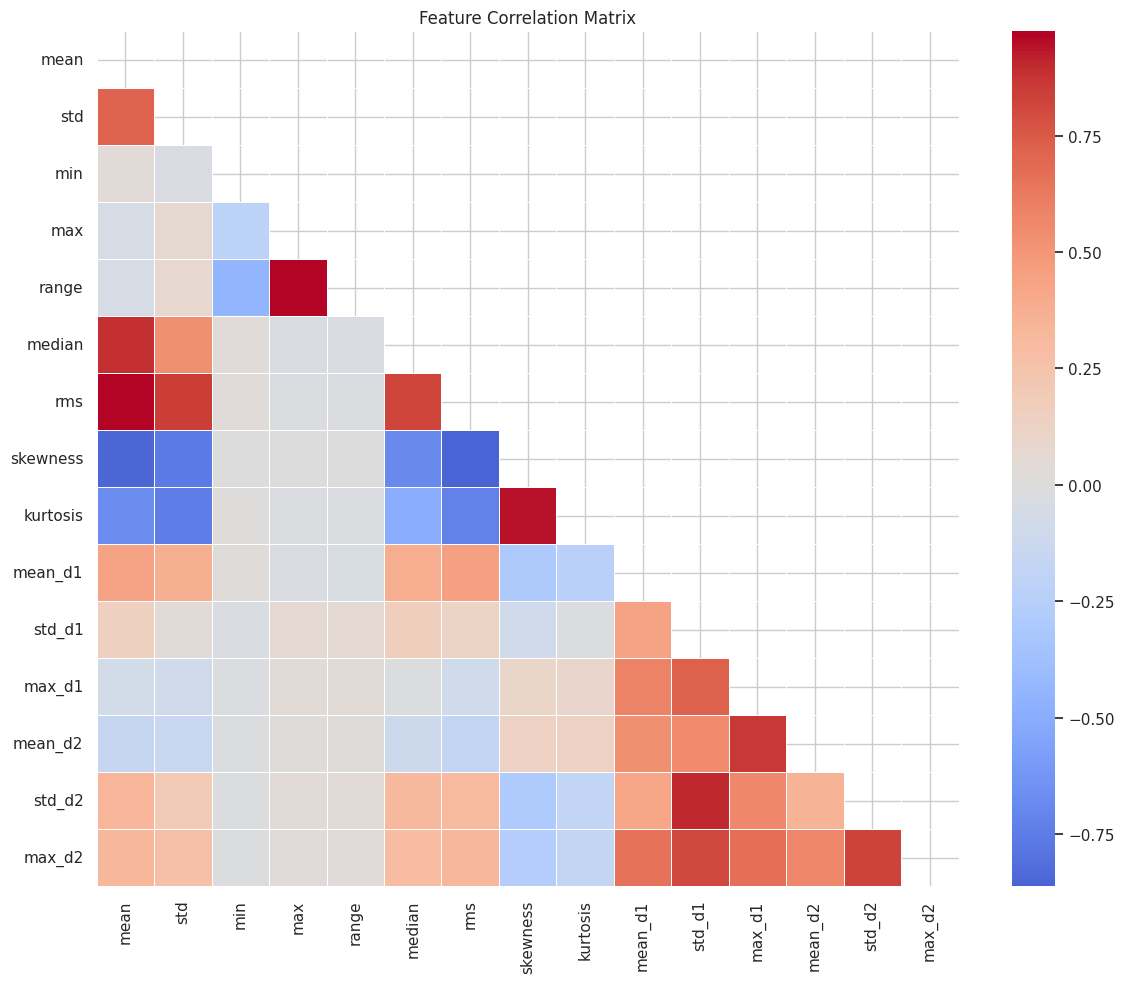

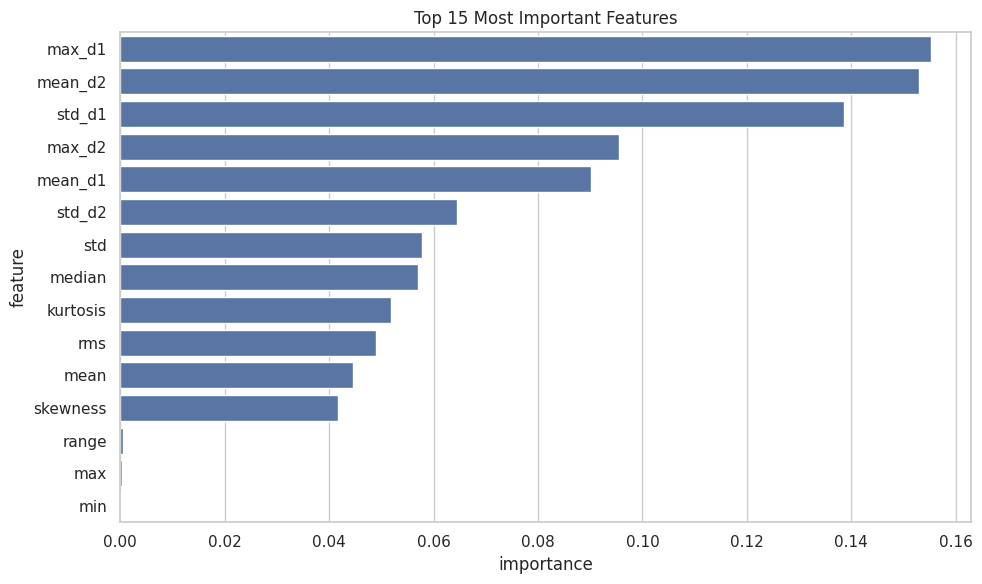


--- Model Training and Evaluation ---
Training set: 99198 samples
Test set: 24800 samples

Training Random Forest...
Accuracy: 0.9710, AUC: 0.9906
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18927
           1       0.98      0.90      0.94      5873

    accuracy                           0.97     24800
   macro avg       0.97      0.95      0.96     24800
weighted avg       0.97      0.97      0.97     24800


Training Gradient Boosting...
Accuracy: 0.9444, AUC: 0.9669
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     18927
           1       0.95      0.81      0.87      5873

    accuracy                           0.94     24800
   macro avg       0.95      0.90      0.92     24800
weighted avg       0.94      0.94      0.94     24800


Training SVM...
Accuracy: 0.9490, AUC: 0.9675
Classification Report:
              precisi

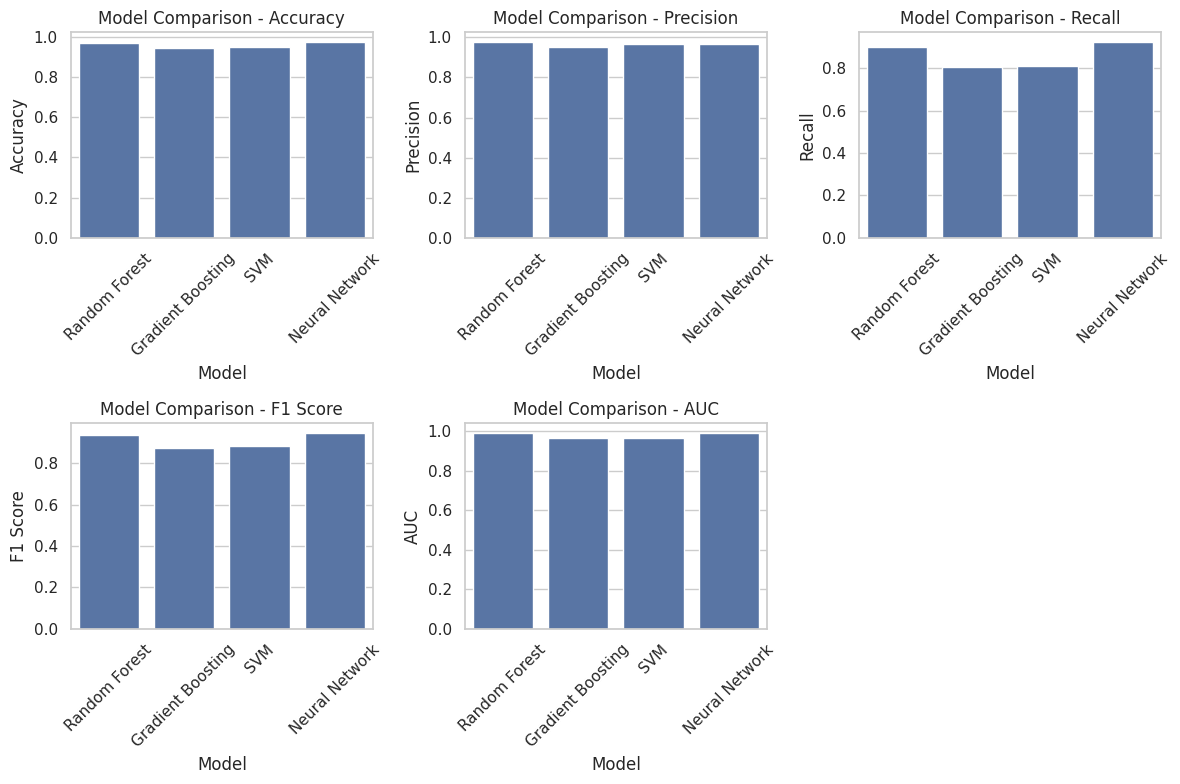


Best model: Random Forest (AUC = 0.9906)


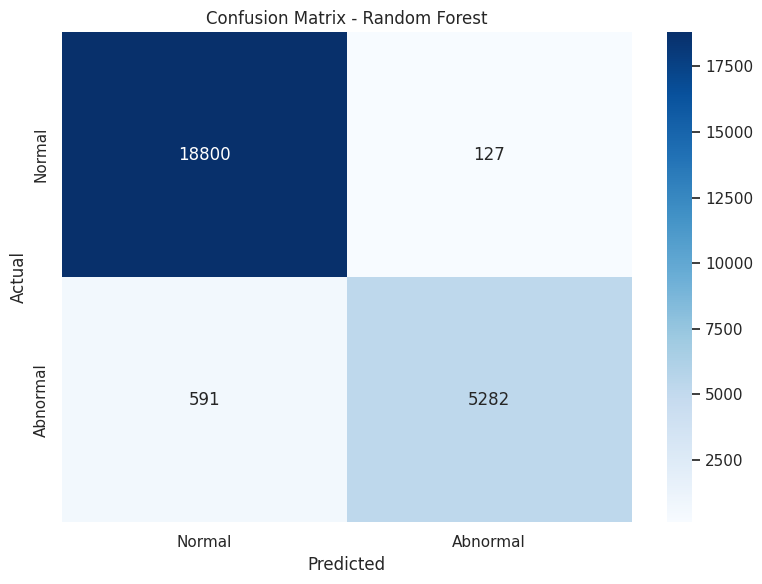

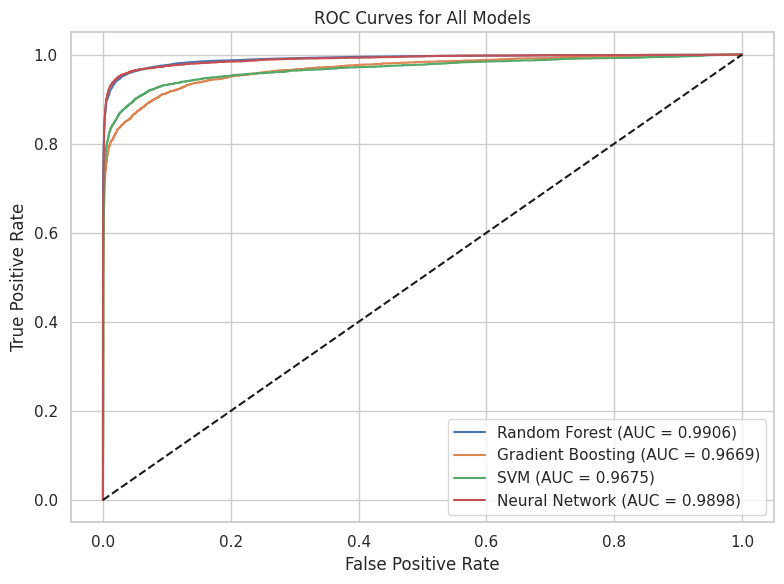

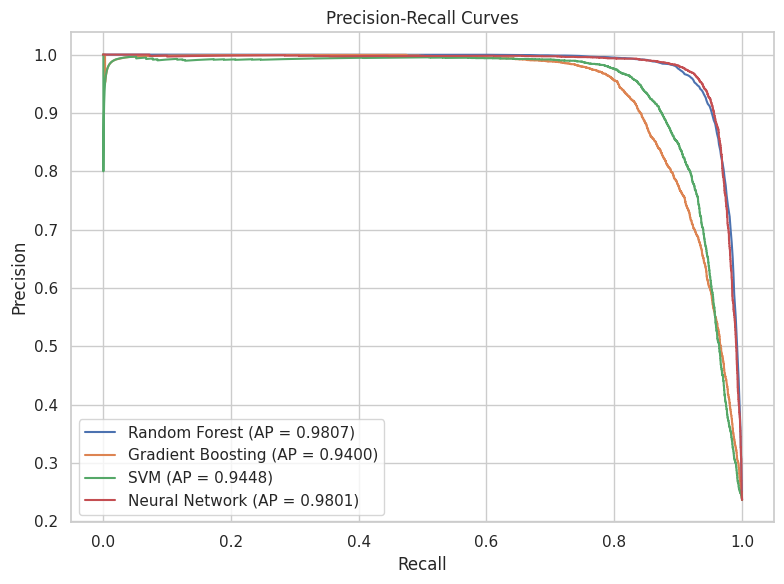

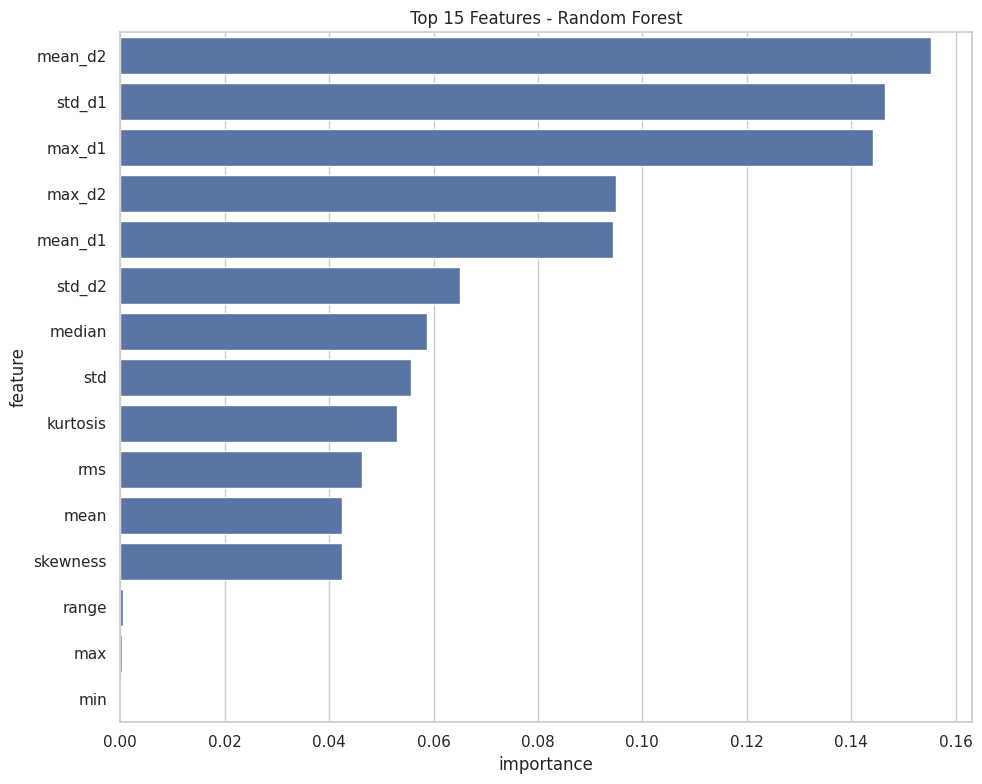


--- Hyperparameter Tuning ---
Tuning Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation AUC: 0.9917
Tuned model AUC on test set: 0.9908
Classification Report for Tuned Model:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18927
           1       0.98      0.90      0.94      5873

    accuracy                           0.97     24800
   macro avg       0.97      0.95      0.96     24800
weighted avg       0.97      0.97      0.97     24800



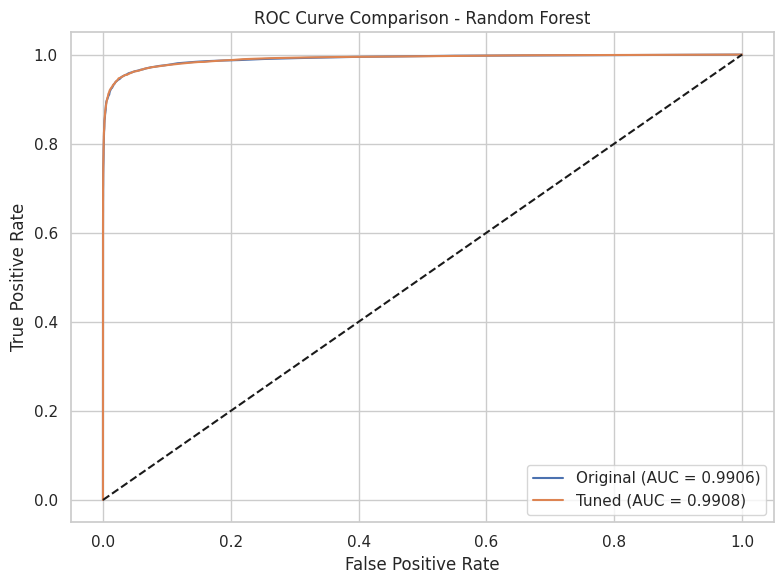


--- Dimensionality Reduction Analysis ---
Original features: 15
PCA features: 7 (95% variance retained)
Explained variance ratio: [0.37113913 0.25371303 0.14472545 0.06046125 0.05613367 0.04568478
 0.02761986]
PCA model AUC: 0.9812
Classification Report for PCA Model:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     18927
           1       0.95      0.86      0.90      5873

    accuracy                           0.96     24800
   macro avg       0.95      0.92      0.94     24800
weighted avg       0.96      0.96      0.95     24800


--- Creating Pipeline for Production ---
Pipeline AUC: 0.9913
Pipeline Accuracy: 0.9716

--- Summary of ECG Classification Analysis ---
Best model: Random Forest
AUC improvement after tuning: 0.0002
Best features: max_d1, mean_d2, std_d1, max_d2, mean_d1
Total samples analyzed: 123998
Class distribution:
  - Normal: 94635 (76.3%)
  - Abnormal: 29363 (23.7%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 1. Data Loading
print("Loading datasets...")
# 1) MIT-BIH
mitbih_train = pd.read_csv("/content/drive/MyDrive/ECG_ML/mitbih_train.csv", header=None)
mitbih_test = pd.read_csv("/content/drive/MyDrive/ECG_ML/mitbih_test.csv", header=None)

# 2) PTB-DB
ptbdb_normal = pd.read_csv("/content/drive/MyDrive/ECG_ML/ptbdb_normal.csv", header=None)
ptbdb_abnormal = pd.read_csv("/content/drive/MyDrive/ECG_ML/ptbdb_abnormal.csv", header=None)

# Print shapes
print("Dataset shapes:")
print("MIT-BIH train:", mitbih_train.shape)
print("MIT-BIH test:", mitbih_test.shape)
print("PTB-DB normal:", ptbdb_normal.shape)
print("PTB-DB abnormal:", ptbdb_abnormal.shape)

# 2. Initial Exploratory Data Analysis (EDA)
print("\n--- Initial EDA ---")

# 2.1 MIT-BIH class distribution
print("\nMIT-BIH train class distribution:")
print(mitbih_train.iloc[:, -1].value_counts())

# Convert MIT-BIH to binary classification
def mitbih_to_binary(label):
    return 0 if label == 0 else 1

# 2.2 Prepare datasets
# MIT-BIH train
X_mitbih_train = mitbih_train.iloc[:, :-1]
y_mitbih_train_orig = mitbih_train.iloc[:, -1]
y_mitbih_train_binary = y_mitbih_train_orig.apply(mitbih_to_binary)

# MIT-BIH test
X_mitbih_test = mitbih_test.iloc[:, :-1]
y_mitbih_test_orig = mitbih_test.iloc[:, -1]
y_mitbih_test_binary = y_mitbih_test_orig.apply(mitbih_to_binary)

# PTB-DB
ptbdb_normal['label'] = 0
ptbdb_abnormal['label'] = 1
ptbdb_combined = pd.concat([ptbdb_normal, ptbdb_abnormal], axis=0)
X_ptbdb = ptbdb_combined.iloc[:, :-1]
y_ptbdb = ptbdb_combined.iloc[:, -1]

print("\nPTB-DB class distribution:")
print(y_ptbdb.value_counts())

# 2.3 Visualize sample signals
plt.figure(figsize=(15, 10))

# MIT-BIH samples (from each class in original classification)
classes = y_mitbih_train_orig.unique()
for i, cls in enumerate(classes):
    plt.subplot(len(classes)+2, 1, i+1)
    sample_idx = y_mitbih_train_orig[y_mitbih_train_orig == cls].index[0]
    plt.plot(X_mitbih_train.iloc[sample_idx])
    plt.title(f"MIT-BIH Class {cls} Sample")
    plt.ylabel("Amplitude")

# PTB-DB samples (normal and abnormal)
for i, label in enumerate([0, 1]):
    plt.subplot(len(classes)+2, 1, len(classes)+i+1)
    sample_idx = y_ptbdb[y_ptbdb == label].index[0]
    plt.plot(X_ptbdb.iloc[sample_idx])
    plt.title(f"PTB-DB {'Normal' if label==0 else 'Abnormal'} Sample")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.savefig('ecg_samples.png')
plt.show()

# 2.4 Signal statistics
def compute_signal_stats(X):
    """Compute basic statistics for each signal."""
    stats = {
        'mean': X.mean(axis=1),
        'std': X.std(axis=1),
        'min': X.min(axis=1),
        'max': X.max(axis=1),
        'range': X.max(axis=1) - X.min(axis=1),
        'median': X.median(axis=1)
    }
    return pd.DataFrame(stats)

# Compute stats for both datasets
mitbih_stats = compute_signal_stats(X_mitbih_train)
mitbih_stats['dataset'] = 'MIT-BIH'
mitbih_stats['label'] = y_mitbih_train_binary.values

ptbdb_stats = compute_signal_stats(X_ptbdb)
ptbdb_stats['dataset'] = 'PTB-DB'
ptbdb_stats['label'] = y_ptbdb.values

combined_stats = pd.concat([mitbih_stats, ptbdb_stats], axis=0)

# Plot distribution of signal statistics by dataset and class
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
stats_to_plot = ['mean', 'std', 'range', 'max', 'min', 'median']
for i, stat in enumerate(stats_to_plot):
    row, col = i // 2, i % 2
    sns.boxplot(x='dataset', y=stat, hue='label', data=combined_stats, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of Signal {stat.capitalize()} by Dataset and Class')
    axes[row, col].set_ylabel(stat.capitalize())
    axes[row, col].legend(title='Class', labels=['Normal', 'Abnormal'])

plt.tight_layout()
plt.savefig('signal_stats.png')
plt.show()

# 3. Data Preprocessing and Feature Engineering
print("\n--- Data Preprocessing ---")

# 3.1 Combine datasets for binary classification
X_mitbih_all = pd.concat([X_mitbih_train, X_mitbih_test], axis=0)
y_mitbih_all = pd.concat([y_mitbih_train_binary, y_mitbih_test_binary], axis=0)

# 3.2 Check for missing values
print("\nMissing values in MIT-BIH:", X_mitbih_all.isnull().sum().sum())
print("Missing values in PTB-DB:", X_ptbdb.isnull().sum().sum())

# 3.3 Feature Engineering - Extract time-domain features
def extract_time_features(signals_df):
    """Extract common time-domain ECG features."""
    features = pd.DataFrame()

    # Basic statistics
    features['mean'] = signals_df.mean(axis=1)
    features['std'] = signals_df.std(axis=1)
    features['min'] = signals_df.min(axis=1)
    features['max'] = signals_df.max(axis=1)
    features['range'] = features['max'] - features['min']
    features['median'] = signals_df.median(axis=1)

    # Calculate RMS (Root Mean Square)
    features['rms'] = np.sqrt((signals_df**2).mean(axis=1))

    # Skewness and Kurtosis
    features['skewness'] = signals_df.skew(axis=1)
    features['kurtosis'] = signals_df.kurtosis(axis=1)

    # First and second derivatives statistics
    for df in [signals_df.diff(axis=1).iloc[:, 1:], signals_df.diff(axis=1).diff(axis=1).iloc[:, 2:]]:
        suffix = '_d1' if len(df.columns) > len(signals_df.columns) - 2 else '_d2'
        features[f'mean{suffix}'] = df.mean(axis=1)
        features[f'std{suffix}'] = df.std(axis=1)
        features[f'max{suffix}'] = df.max(axis=1)

    return features

# Extract features from both datasets
X_mitbih_features = extract_time_features(X_mitbih_all)
X_ptbdb_features = extract_time_features(X_ptbdb)

# 3.4 Combine all data with engineered features
# Option 1: Use raw signals
X_combined_raw = pd.concat([X_mitbih_all, X_ptbdb], axis=0)
y_combined = pd.concat([y_mitbih_all, y_ptbdb], axis=0)

# Option 2: Use engineered features
X_combined_features = pd.concat([X_mitbih_features, X_ptbdb_features], axis=0)

print("\nRaw data shape:", X_combined_raw.shape)
print("Engineered features shape:", X_combined_features.shape)
print("Combined labels shape:", y_combined.shape)

# 3.5 Class distribution visualization
plt.figure(figsize=(8, 5))
sns.countplot(x=y_combined)
plt.title("Class Distribution (Combined Dataset)")
plt.xlabel("Class (0=Normal, 1=Abnormal)")
plt.ylabel("Count")
plt.savefig('class_distribution.png')
plt.show()

# 3.6 Feature correlations (for engineered features)
plt.figure(figsize=(12, 10))
correlation_matrix = X_combined_features.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig('feature_correlations.png')
plt.show()

# 3.7 Feature importance visualization using a preliminary model
def plot_feature_importance(X, y, feature_names):
    # Train a simple random forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get feature importances
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances.head(15))
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    return importances

# Plot feature importance for engineered features
feature_importances = plot_feature_importance(X_combined_features, y_combined, X_combined_features.columns)

# 4. Model Training and Evaluation
print("\n--- Model Training and Evaluation ---")

# 4.1 Split the data
# For engineered features
X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_combined_features, y_combined,
    test_size=0.2,
    random_state=42,
    stratify=y_combined
)

print(f"Training set: {X_train_features.shape[0]} samples")
print(f"Test set: {X_test_features.shape[0]} samples")

# 4.2 Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# 4.3 Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    accuracy = model.score(X_test_scaled, y_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score'],
        'auc': auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

    print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# 4.4 Compare models
metrics_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'Precision': [results[model]['precision'] for model in results],
    'Recall': [results[model]['recall'] for model in results],
    'F1 Score': [results[model]['f1'] for model in results],
    'AUC': [results[model]['auc'] for model in results]
})

# Plot comparison
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df)
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# 4.5 Best model detailed evaluation
# Find best model based on AUC
best_model_name = metrics_df.loc[metrics_df['AUC'].idxmax(), 'Model']
best_model = results[best_model_name]
print(f"\nBest model: {best_model_name} (AUC = {best_model['auc']:.4f})")

# Confusion Matrix
cm = confusion_matrix(y_test, best_model['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig('best_model_confusion_matrix.png')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves.png')
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_proba'])
    avg_precision = average_precision_score(y_test, result['y_proba'])
    plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig('precision_recall_curves.png')
plt.show()

# 5. Feature Importance Analysis for Best Model
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Get feature importance for tree-based models
    model = best_model['model']
    importances = pd.DataFrame({
        'feature': X_combined_features.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importances.head(15))
    plt.title(f'Top 15 Features - {best_model_name}')
    plt.tight_layout()
    plt.savefig('best_model_feature_importance.png')
    plt.show()

# 6. Hyperparameter Tuning for Best Model
print("\n--- Hyperparameter Tuning ---")

# Define parameter grids for each model type
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1],
        'kernel': ['rbf', 'linear']
    },
    'Neural Network': {
        'hidden_layer_sizes': [(64,), (64, 32), (100, 50, 25)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

if best_model_name in param_grids:
    print(f"Tuning {best_model_name}...")

    # Create model instance
    model_class = type(best_model['model'])
    base_model = model_class()

    # Create grid search
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grids[best_model_name],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)

    # Best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test_scaled)
    y_proba_tuned = tuned_model.predict_proba(X_test_scaled)[:, 1]

    auc_tuned = roc_auc_score(y_test, y_proba_tuned)
    print(f"Tuned model AUC on test set: {auc_tuned:.4f}")
    print(f"Classification Report for Tuned Model:\n{classification_report(y_test, y_pred_tuned)}")

    # Compare original vs tuned model
    plt.figure(figsize=(8, 6))
    # Original model ROC
    fpr_orig, tpr_orig, _ = roc_curve(y_test, best_model['y_proba'])
    plt.plot(fpr_orig, tpr_orig, label=f"Original (AUC = {best_model['auc']:.4f})")

    # Tuned model ROC
    fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
    plt.plot(fpr_tuned, tpr_tuned, label=f"Tuned (AUC = {auc_tuned:.4f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve Comparison - {best_model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('tuned_model_roc.png')
    plt.show()

# 7. Dimensionality Reduction Analysis
print("\n--- Dimensionality Reduction Analysis ---")

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA features: {X_train_pca.shape[1]} (95% variance retained)")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Train best model on PCA features
pca_model = type(best_model['model'])(**grid_search.best_params_ if 'grid_search' in locals() else {})
pca_model.fit(X_train_pca, y_train)

# Evaluate
y_pred_pca = pca_model.predict(X_test_pca)
y_proba_pca = pca_model.predict_proba(X_test_pca)[:, 1]
auc_pca = roc_auc_score(y_test, y_proba_pca)

print(f"PCA model AUC: {auc_pca:.4f}")
print(f"Classification Report for PCA Model:\n{classification_report(y_test, y_pred_pca)}")

# 8. Pipeline for Production
print("\n--- Creating Pipeline for Production ---")

# Create a pipeline including preprocessing and the best model
if 'tuned_model' in locals():
    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', tuned_model)
    ])
else:
    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', best_model['model'])
    ])

# Fit the pipeline on the training data
best_pipeline.fit(X_train_features, y_train)

# Test the pipeline
pipeline_predictions = best_pipeline.predict(X_test_features)
pipeline_probas = best_pipeline.predict_proba(X_test_features)[:, 1]
pipeline_auc = roc_auc_score(y_test, pipeline_probas)

print(f"Pipeline AUC: {pipeline_auc:.4f}")
print(f"Pipeline Accuracy: {(pipeline_predictions == y_test).mean():.4f}")

# 9. Summary
print("\n--- Summary of ECG Classification Analysis ---")
print(f"Best model: {best_model_name}")
if 'tuned_model' in locals():
    print(f"AUC improvement after tuning: {auc_tuned - best_model['auc']:.4f}")
print(f"Best features: {', '.join(feature_importances['feature'].head(5).values)}")
print(f"Total samples analyzed: {len(y_combined)}")
print("Class distribution:")
print(f"  - Normal: {(y_combined == 0).sum()} ({(y_combined == 0).mean()*100:.1f}%)")
print(f"  - Abnormal: {(y_combined == 1).sum()} ({(y_combined == 1).mean()*100:.1f}%)")